# Make buoy data file

Standardize buoy data and put it together in a Pandas dataframe.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from datetime import datetime, timedelta
import datedelta
import gsw

/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
base = 'drive_data/'

In [3]:
# read in buoy info
bys = pd.read_csv(base + 'buoys.csv', index_col=0).to_dict('index')

buoys = {'BOLI': {'ll': ([-94.783, 29.342]), 'color': '#689F38', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'MIDG': {'ll': ([-94.875, 29.508]),  'color': '#FBC02D', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'FISH': {'ll': ([-94.854, 29.670]),  'color': '#F57C00', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'TRIN': {'ll': ([-94.746, 29.661]),  'color': '#FFA000', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'OLDR': {'ll': ([-94.783, 29.833]), 'color': '#D32F2F', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         '08078000': {'ll': ([-95.32283, 29.3713056]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08077600': {'ll': ([-95.1783, 29.5172]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08074500': {'ll': ([-95.39694, 29.775]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08068500': {'ll': ([-95.4361, 30.110278]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08068090': {'ll': ([-95.3382, 30.141167]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08070500': {'ll': ([-95.302, 30.2594]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08071000': {'ll': ([-95.168056, 30.23250]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08070200': {'ll': ([-95.124167, 30.145278]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08071280': {'ll': ([-95.05972, 30.1094]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08067252': {'ll': ([-94.731, 29.812]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08067000': {'ll': ([-94.818056, 30.0575]), 'color': 'r', 'vars': ['Rain [cm]']},
         '08077650': {'ll': ([-94.92, 29.4472]), 'color': 'r', 'vars': ['Rain [cm]']},
         '08073600': {'ll': ([-95.55750, 29.76194]), 'color': 'r', 'vars': ['Rain [cm]']},
         '8771486': {'ll': ([bys['8771486']['lon'], bys['8771486']['lat']]),  'color': '#0097A7',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770613': {'ll': ([bys['8770613']['lon'], bys['8770613']['lat']]),  'color': '#E64A19',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                              'Salinity']},
         '8771013': {'ll': ([bys['8771013']['lon'], bys['8771013']['lat']]), 'color': '#AFB42B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                              'Salinity']},
         '8771341': {'ll': ([bys['8771341']['lon'], bys['8771341']['lat']]), 'color': '#388E3C',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                             'AtmPr [MB]']},
         '8771450': {'ll': ([bys['8771450']['lon'], bys['8771450']['lat']]), 'color': '#00796B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                             'AtmPr [MB]']},
         'B': {'ll': ([bys['B']['lon'], bys['B']['lat']]), 'color': '#303F9F',
                     'vars': ['AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]', 'Salinity', 
                              'Along [cm/s]', 'Across [cm/s]']},
         'g06010': {'ll': ([bys['g06010']['lon'], bys['g06010']['lat']]), 'color': '#388E3C',
                     'vars': ['Along [cm/s]', 'Across [cm/s]', 'WaterT [deg C]']},
         '42035': {'ll': ([bys['42035']['lon'], bys['42035']['lat']]), 'color': '#5D4037',
                     'vars': ['AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770808': {'ll': ([bys['8770808']['lon'], bys['8770808']['lat']]), 'color': '#512DA8',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770777': {'ll': ([bys['8770777']['lon'], bys['8770777']['lat']]), 'color': '#C2185B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770822': {'ll': ([bys['8770822']['lon'], bys['8770822']['lat']]), 'color': '#455A64',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770971': {'ll': ([bys['8770971']['lon'], bys['8770971']['lat']]), 'color': '#7B1FA2',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8771972': {'ll': ([bys['8771972']['lon'], bys['8771972']['lat']]), 'color': '#0288D1',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']}
        }


buoys_ordered = ['8770777', '8770613', 'OLDR', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341',
                '8771450', '8771486', '8771972', '8770971', '8770808', 'B', '42035', '8770822']
# buoys down main bay
buoys_main = ['8770613', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341', '8771450']

In [4]:
savename = base + 'data.csv'
dstart = '2017-06-01'; dend = '2017-12-31'
tz = 'UTC'  # 'US/Central'
baseurl = 'http://pong.tamu.edu/'  # or 'http://localhost/'


## Improve BOLI water depth data

At the BOLI station, there is a pressure sensor attached to the mount, which is 4.2 meters below the surface, that measures the amount of water above it to give a water depth. But, the vertical datum isn't known so this vertical shift is a constant in the analysis that needs to be backed out, the data has regular sharps jumps, and it is not vented to the atmosphere, meaning that the pressure measured includes atmospheric changes at the surface. I perform the following adjustments:

1. rolling mean to smooth out the jumps
1. correct for atmospheric pressure.

### Correct for atmospheric pressure

Use hydrostatic relationship to do this. For the depth of the instrument pressure sensor below the sea surface, $z=-z_s$ to the sea surface $\eta$, we have

$
\begin{align}
    \int^\eta_{-z_s} P_z &= \int^\eta_{-z_s} -g\rho_0 \\
    \left.P\right|_\eta - \left.P\right|_{-z_s} &= -\left.g\rho_0 z \right|^\eta_{-z_s} \\
    ~ &= -g\rho_0 (\eta+z_s) \\
    z_s &= \frac{P_{-z_s} - P_\eta}{g\rho_0} - \eta \\
    ~ &= \frac{P_{-z_s}}{g\rho_0} - \eta - \frac{P_\eta}{g\rho_0}
\end{align}
$

From the final line we find that we should add $\frac{P_\eta}{g\rho_0}$ to the TWDB depth data to correct the measurement for atmospheric pressure.

In [5]:
g = 9.81  # m/s^2
if not os.path.exists(savename):
        
    ## River inflow to Trinity Bay ##
    # https://txpub.usgs.gov/txwaterdashboard/index.html
    # direct link, read in as local time
    # USGS 08078000 Chocolate Bayou nr Alvin, TX (drains into west bay)
    # USGS 08077600 Clear Ck nr Friendswood, TX (drains in north of Eagle Pt)
    # USGS 08074500 Whiteoak Bayou at Houston, TX (drains into north end of bay)
    # all going into San Jac, north end of bay:
    #  USGS 08068500 Spring Ck nr Spring, TX
    #  USGS 08068090 W Fk San Jacinto Rv abv Lk Houston nr Porter, TX
    #  USGS 08070500 Caney Ck nr Splendora, TX
    #  USGS 08071000 Peach Ck at Splendora, TX
    #  USGS 08070200 E Fk San Jacinto Rv nr New Caney, TX
    #  USGS 08071280 Luce Bayou abv Lk Houston nr Huffman, TX
    # USGS 08067252 Trinity Rv at Wallisville, TX (Trinity river)
    i=0
    stations = ['08078000', '08077600', '08074500', '08068500', '08068090', '08070500', '08071000', 
                '08070200', '08071280', '08067252']  # '08067070'
    for station in stations:
        url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no=' + station + '&period=&begin_date=' \
                + dstart + '&end_date=' + dend
        river = pd.read_table(url, parse_dates=True, comment='#', header=1, usecols=[2,4], index_col=0,
                         names=['Dates [UTC]', station + ': Flow rate [m^3/s]'])[dstart:dend].tz_localize('US/Central', ambiguous=True).tz_convert('UTC')
        river = river*0.3048**3  # to m^3/s
        river = river.resample('1H', base=0).mean()
        if i==0:
            df = pd.DataFrame(index=river.index, data=river)
            i += 1
        else:
            df[station + ': Flow rate [m^3/s]'] = river

#     # direct link, read in as local time
#     station = '08067252'  # '08067070'
#     url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no=' + station + '&period=&begin_date=' \
#             + dstart + '&end_date=' + dend
#     river = pd.read_table(url, parse_dates=True, skiprows=29, header=None, usecols=[2,4], index_col=0,
#                      names=['Dates [UTC]', station + ': Trinity flow rate [m^3/s]'])[dstart:dend].tz_localize('US/Central', ambiguous=True).tz_convert('UTC')
#     river = river*0.3048**3  # to m^3/s
#     river = river.resample('1H', base=0).mean()
#     df = pd.DataFrame(index=river.index, data=river)
#     df = pd.read_csv('drive_data/data-partial.csv', parse_dates=True, index_col=0, usecols=[0,1]).tz_localize('UTC')
    
    ## TWDB ##
    names = ['FISH', 'MIDG', 'OLDR', 'TRIN', 'BOLI']
    Files = ['seawater_salinity', 'water_depth_nonvented', 'water_temperature']
    filenames = ['Salinity', 'Depth [m]', 'WaterT [deg C]']
    base = 'https://waterdatafortexas.org/coastal/api/stations/' 
    for name  in names:
        for File, filename  in zip(Files, filenames):
            # read in as UTC
            url = base + name + '/data/' + File + '?output_format=csv&binning=hour'
            dft = pd.read_csv(url, index_col=0,
                             parse_dates=True, comment='#', header=0, names=['dates [local]', filename])[dstart:dend].tz_localize('UTC')
            dft = dft.resample('1H', base=0).mean()
            df[name + ': ' + filename] = dft

    ## TABS ##
    for table in ['met', 'salt', 'ven']:
        url = baseurl + 'tabswebsite/subpages/tabsquery.php?Buoyname=B&table=' + table + '&Datatype=download&units=M&tz=UTC&model=False&datepicker='
        url += dstart + '+-+' + dend
        dft = pd.read_table(url, parse_dates=True, index_col=0, na_values=-999)[dstart:dend].tz_localize('UTC')
        dft = dft.resample('1H', base=0).mean()
        for var in buoys['B']['vars']:
            if var in dft.columns:
                df['B: ' + var] = dft[var]
        
    
    ## NOS/NDBC buoys ##
    for buoy in buoys:
        if len(buoy) < 5 or buoy == 'g06010' or len(buoy) == 8:
            continue
        url = baseurl + 'tabswebsite/subpages/tabsquery.php?Buoyname=' + buoy + '&Datatype=download&units=M&tz=UTC&model=False&datepicker='
        url += dstart + '+-+' + dend
        dft = pd.read_table(url, parse_dates=True, index_col=0, na_values=-999)[dstart:dend].tz_localize('UTC')
        dft = dft.resample('1H', base=0).mean()
        for var in buoys[buoy]['vars']:
            if var in dft.columns:
                df[buoy + ': ' + var] = dft[var]
    
    ## Vertical datum
    # The vertical datum for the bathymetry is mean high water (in file "Galveston_DEM_metadata.html"). 
    # The sea level measurements that I use are in mean sea level, so need to adjust.
    # using station datum information from e.g. https://tidesandcurrents.noaa.gov/datums.html?id=8771013
    df['8771013: Water Level [m]'] -= (1.610 - 1.467)  # MHW - MSL datums, meters
    df['8771341: Water Level [m]'] -= (3.249 - 3.072)  # MHW - MSL datums, meters
    df['8770777: Water Level [m]'] -= (2.140 - 1.951)  # MHW - MSL datums, meters
    df['8770613: Water Level [m]'] -= (1.967 - 1.807)  # MHW - MSL datums, meters
    df['8771450: Water Level [m]'] -= (1.739 - 1.588)  # MHW - MSL datums, meters
    df['8771486: Water Level [m]'] -= (6.311 - 6.183)  # MHW - MSL datums, meters
    df['8771972: Water Level [m]'] -= (1.621 - 1.498)  # MHW - MSL datums, meters
    df['8770971: Water Level [m]'] -= (1.425 - 1.259)  # MHW - MSL datums, meters
    df['8770808: Water Level [m]'] -= (4.462 - 4.299)  # MHW - MSL datums, meters
    df['8770822: Water Level [m]'] -= (1.507 - 1.308)  # MHW - MSL datums, meters
    
    
    ## currents with depth in entrance channel ##
    # have to loop over each month
    url = 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=sea_water_speed&direction_of_sea_water_velocity&offering=urn:ioos:station:NOAA.NOS.CO-OPS:g06010&responseFormat=text/csv&eventTime='
    # along-channel direction
    diralong = 90 - bys['g06010']['angle']
    if diralong < 0:
        diralong += 360
    
    dst = pd.Timestamp(dstart)
    while dst < pd.Timestamp('2017-12-31'):
        dst += datedelta.MONTH  # skip first month because missing first half of data
        den = dst + datedelta.MONTH - pd.Timedelta('1 hour')

        # read in data for month
        d = pd.read_csv(url + dst.strftime('%Y-%m-%dT00:00:00Z/') + den.strftime('%Y-%m-%dT%H:%M:%SZ'), parse_dates=True, index_col=4).tz_localize('UTC')
        d = d[['sea_water_speed (cm/s)', 'direction_of_sea_water_velocity (degree)', 'sea_water_temperature (C)', 'bin_distance (m)']]

        # pivot to get times as rows and depths as columns
        d = pd.pivot_table(d, index=['bin_distance (m)', 'date_time'] )
        depths = d.index.get_level_values(0).drop_duplicates().get_values()

        # initialize columns
        if not 'g06010: Along [cm/s], depth ' + str(depths[0]) + ' [m]' in df.columns:
            for depth in depths:
                df['g06010: Along [cm/s], depth ' + str(depth) + ' [m]'] = np.nan
                df['g06010: Across [cm/s], depth ' + str(depth) + ' [m]'] = np.nan
                df['g06010: WaterT [deg C]'] = np.nan

        # calculations
        for depth in depths:

            theta = d.loc[depth]['direction_of_sea_water_velocity (degree)'].copy()
            # convert to math angles
            theta = 90 - theta
            theta[theta<0] += 360

            # calculate u and v
            east = d.loc[depth]['sea_water_speed (cm/s)']*np.cos(np.deg2rad(theta))
            north = d.loc[depth]['sea_water_speed (cm/s)']*np.sin(np.deg2rad(theta))

            # calculate along and across velocity
            df['g06010: Along [cm/s], ' + 'depth ' + str(depth) + ' [m]'].loc[dst.isoformat():den.isoformat()] = (east*np.cos(np.deg2rad(diralong)) + north*np.sin(np.deg2rad(diralong))).resample('1H', base=0).mean()
            df['g06010: Across [cm/s], ' + 'depth ' + str(depth) + ' [m]'].loc[dst.isoformat():den.isoformat()] = (-east*np.sin(np.deg2rad(diralong)) + north*np.cos(np.deg2rad(diralong))).resample('1H', base=0).mean()
        df['g06010: WaterT [deg C]'].loc[dst.isoformat():den.isoformat()] = d.loc[depth]['sea_water_temperature (C)'].resample('1H', base=0).mean()
            
    ## Precipitation data ##
    # USGS 08067000 Trinity Rv at Liberty, TX
    # USGS 08077650 Moses Lk-Galveston Bay nr Texas City, TX;
    # USGS 08073600 Buffalo Bayou at W Belt Dr, Houston, TX
    stations = ['08067000', '08077650', '08073600']
    for station in stations:
        # rain is in inches
        rain = pd.read_csv('drive_data/' + station + '-precip.csv', comment='#', parse_dates=True, index_col=0, usecols=[0,2]).tz_localize('UTC')
        rain *= 2.54  # convert from inches to centimeters
        df[station + ': Rain [cm]'] = rain
            
    ## Correct BOLI depth data ##
    # rolling mean of BOLI depth to smooth out jumps
    df['BOLI: Depth [m], smoothed'] = df['BOLI: Depth [m]'].rolling(window=7, center=True).mean()
    # add atmospheric pressure to BOLI measurement to remove it
    # using depth instead of pressure makes no real difference in calculation of rho since they are so close
    df['BOLI: Density [kg/m^3]'] = gsw.rho(df['BOLI: Salinity'], df['BOLI: WaterT [deg C]'], df['BOLI: Depth [m], smoothed'].data)  # kg/m^3
    df['BOLI: Depth [m], corrected'] = df['BOLI: Depth [m], smoothed'] + (df['8771341: AtmPr [MB]']*100)/(9.81*df['BOLI: Density [kg/m^3]'])  # corrected BOLI depth for atmos press

    df.tz_localize(None).to_csv(savename)
else:
    df = pd.read_csv(savename, parse_dates=True, index_col=0)

In [71]:
df['BOLI: Depth [m], median'] = df['BOLI: Depth [m]'].rolling(window=7, center=True).median()

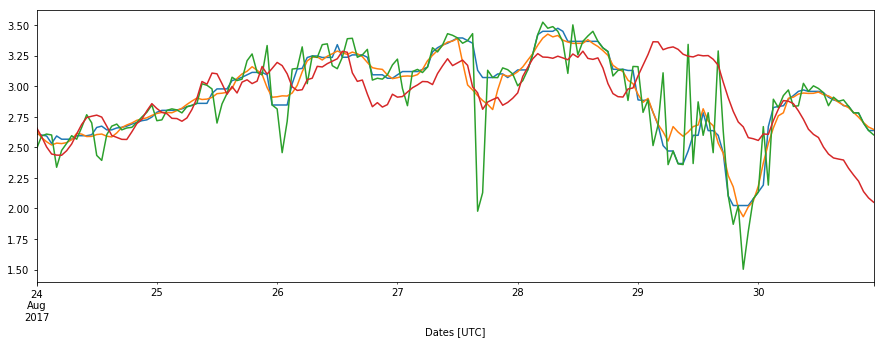

In [72]:
df['BOLI: Depth [m], median']['2017-8-24':'2017-8-30'].plot()
df['BOLI: Depth [m], smoothed']['2017-8-24':'2017-8-30'].plot(figsize=(15,5))
df['BOLI: Depth [m]']['2017-8-24':'2017-8-30'].plot(figsize=(15,5))
(df['8771341: Water Level [m]']+2.6)['2017-8-24':'2017-8-30'].plot(figsize=(15,5))

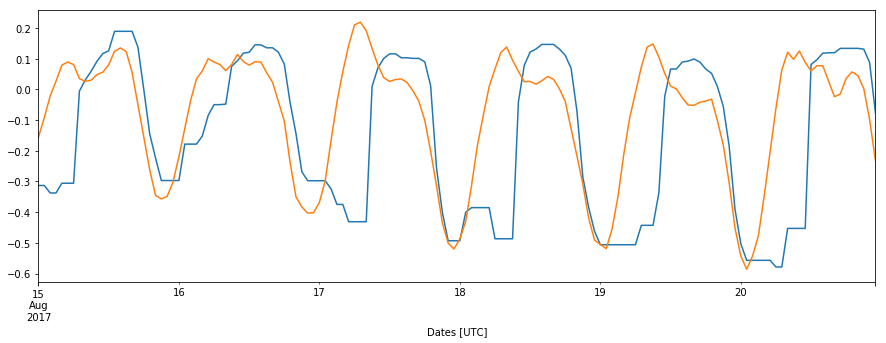

In [73]:
(df['BOLI: Depth [m], median']-2.6)['2017-8-15':'2017-8-20'].plot()
df['8771341: Water Level [m]']['2017-8-15':'2017-8-20'].plot(figsize=(15,5))


In [21]:
    df['BOLI: Depth [m], corrected'] = df['BOLI: Depth [m], smoothed'] - ((df['8771341: AtmPr [MB]']-1013.25)*100)/(9.81*1025)  # corrected BOLI depth for atmos press


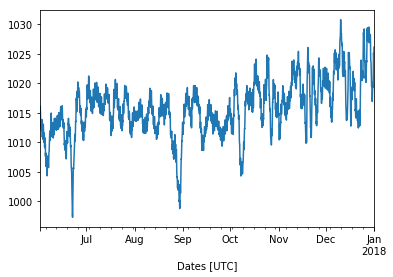

In [13]:
df['8771341: AtmPr [MB]'].plot()

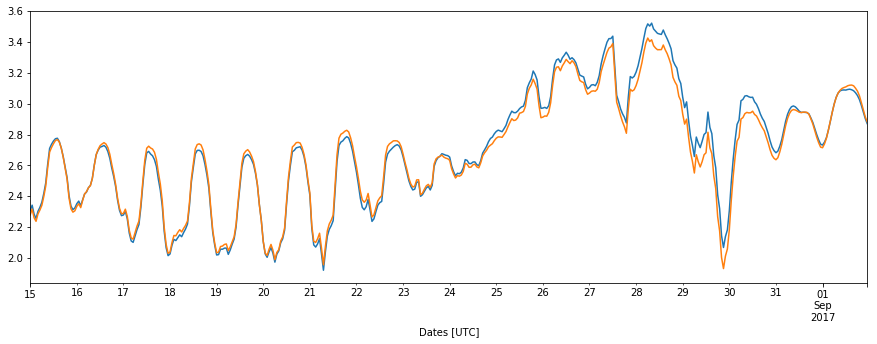

In [22]:
df['BOLI: Depth [m], corrected']['2017-8-15':'2017-9-1'].plot()
df['BOLI: Depth [m], smoothed']['2017-8-15':'2017-9-1'].plot(figsize=(15,5))

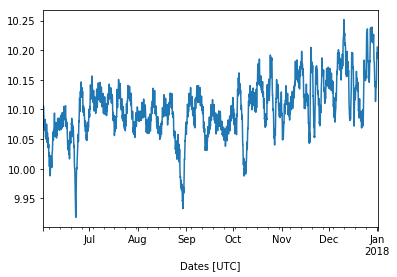

In [10]:
((df['8771341: AtmPr [MB]']*100)/(9.81*1025)).plot()

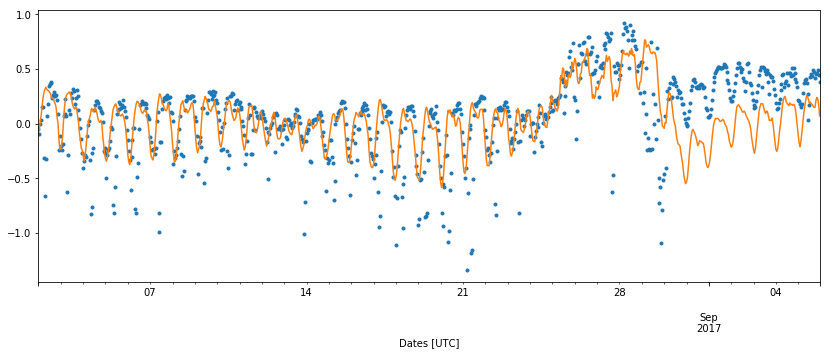

In [109]:
(df['BOLI: Depth [m]']-2.6)['2017-8-2':'2017-9-5'].plot(marker='.', lw=0)
df['8771341: Water Level [m]']['2017-8-2':'2017-9-5'].plot(figsize=(14,5))
# df['BOLI: Depth [m], corrected']['2017-8-20':'2017-9-5'].plot()

In [ ]:
# Can add in other river gauges
# shows gauges: https://stn.wim.usgs.gov/fev/#HarveyAug2017; shows precip: https://txpub.usgs.gov/txwaterdashboard/index.html
# list: https://waterdata.usgs.gov/tx/nwis/current/?type=precip&group_key=county_cd
# USGS 08078000 Chocolate Bayou nr Alvin, TX ,; USGS 08077600 Clear Ck nr Friendswood, TX; 
# USGS 08067525 Goose Ck at Baytown, TX; USGS 08070200 E Fk San Jacinto Rv nr New Caney, TX
# stations = ['08078000', '08077600', '08067525']#, '08070200']
# for station in stations:
#     url = 'https://nwis.waterdata.usgs.gov/tx/nwis/uv/?cb_00060=on&format=rdb&site_no=' + station \
#             + '&period=&begin_date=' + dstart + '&end_date=' + dend

#     river = pd.read_table(url, parse_dates=True, skiprows=29, header=None, usecols=[2,4], index_col=0,
#                      names=['Dates [UTC]', station + ': flow rate [m^3/s]'])[dstart:dend].tz_localize('US/Central', ambiguous=True).tz_convert('UTC')
#     river = river*0.3048**3  # to m^3/s
#     river = river.resample('1H', base=0).mean()
#     df[river.columns[0]] = river

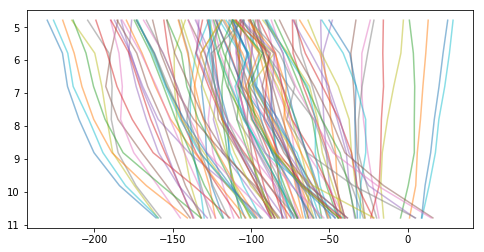

In [255]:
plt.figure(figsize=(8,4))
dates = df['2017-8-27':'2017-8-31'].index
# dates = df.index
s = np.zeros((len(dates), len(depths)))
for i, date in enumerate(dates):
    for j, depth in enumerate(depths):
        s[i,j] = df['g06010: Along [cm/s], depth %s [m]' % depth].loc[date]
plt.plot(s[:,1:].T, depths[1:], '-', alpha=0.5)
#     plt.vlines(s.mean(), depths[0], depths[-1])
plt.gca().invert_yaxis() 

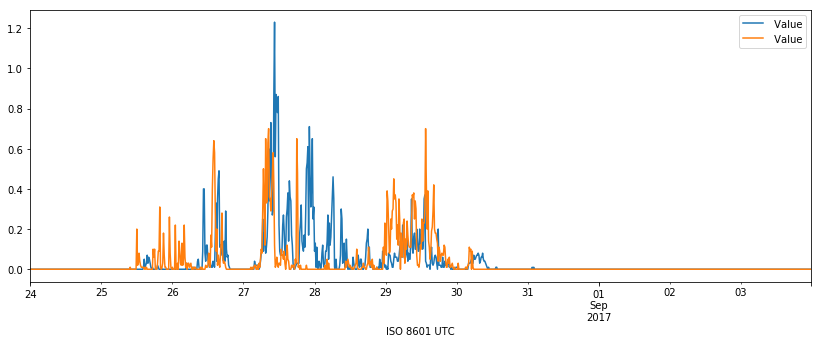

In [274]:
# precipitation data
